In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

/opt/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

/opt/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,unique
activity_id,17
institution_id,35
source_id,79
experiment_id,146
member_id,495
table_id,36
variable_id,665
grid_label,10
zstore,348657
dcpp_init_year,60


In [49]:
col.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
...,...,...,...,...,...,...,...,...,...,...,...
348652,ScenarioMIP,UA,MCM-UA-1-0,ssp585,r1i1p1f2,Omon,vo,gn,gs://cmip6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1...,NaN,20190731
348653,ScenarioMIP,UA,MCM-UA-1-0,ssp585,r1i1p1f2,Omon,wo,gn,gs://cmip6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1...,NaN,20190731
348654,ScenarioMIP,UA,MCM-UA-1-0,ssp585,r1i1p1f2,SImon,sithick,gn,gs://cmip6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1...,NaN,20190731
348655,ScenarioMIP,UA,MCM-UA-1-0,ssp585,r1i1p1f2,fx,areacella,gn,gs://cmip6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1...,NaN,20190731


In [50]:
expts = ['historical', 'ssp126', 'ssp245', 'ssp585']

query = dict(
    experiment_id=expts,
    table_id='Amon',                           
    variable_id=['tas'],
    member_id = 'r1i1p1f1',                     
)

col_subset_all = col.search(require_all_on=["source_id"], **query)
col_subset_any = col.search(**query)

In [45]:
dset_dict = col_subset_any.to_dataset_dict(zarr_kwargs={'consolidated': True})
list(dset_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['ScenarioMIP.INM.INM-CM4-8.ssp245.Amon.gr1',
 'ScenarioMIP.CAMS.CAMS-CSM1-0.ssp126.Amon.gn',
 'ScenarioMIP.CAMS.CAMS-CSM1-0.ssp245.Amon.gn',
 'ScenarioMIP.MIROC.MIROC6.ssp585.Amon.gn',
 'CMIP.NCC.NorCPM1.historical.Amon.gn',
 'ScenarioMIP.CAS.FGOALS-f3-L.ssp585.Amon.gr',
 'ScenarioMIP.NCC.NorESM2-MM.ssp245.Amon.gn',
 'CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Amon.gr',
 'ScenarioMIP.KIOST.KIOST-ESM.ssp245.Amon.gr1',
 'ScenarioMIP.INM.INM-CM5-0.ssp126.Amon.gr1',
 'ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp245.Amon.gr',
 'CMIP.MIROC.MIROC6.historical.Amon.gn',
 'ScenarioMIP.FIO-QLNM.FIO-ESM-2-0.ssp126.Amon.gn',
 'ScenarioMIP.AWI.AWI-CM-1-1-MR.ssp126.Amon.gn',
 'ScenarioMIP.AWI.AWI-CM-1-1-MR.ssp585.Amon.gn',
 'CMIP.AWI.AWI-ESM-1-1-LR.historical.Amon.gn',
 'ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp126.Amon.gn',
 'ScenarioMIP.CAS.FGOALS-g3.ssp126.Amon.gn',
 'ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp126.Amon.gn',
 'CMIP.CCCR-IITM.IITM-ESM.historical.Amon.gn',
 'ScenarioMIP.CAS.FGOALS-g3.ssp245.Amon.gn',
 'Scena

In [6]:
ds = dset_dict['CMIP.NCC.NorCPM1.historical.Amon.gn']
ds

<xarray.Dataset>
Dimensions:    (lat: 96, lon: 144, member_id: 1, time: 2160)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) object 1850-01-16 12:00:00 ... 2029-12-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1080, 96, 144), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             perturbations to atmospheric fields were appli...
    branch_time:               674885.0
    branch_time_in_child:      674885.0
    branch_time_in_parent:     674885.0
    cmor_version:              3.5.0
    contact:                   Please send any requests or bug reports to nor...
    creation_date:             2019-09-21T18:37:42Z
    data_specs_version:        01.00.31
    experiment:                all-forcing simulation of the recent past
    experiment_id:             historical
    external_variables:        areacella
    forcing_index:             1
    frequency:                 mon
    further_info_url:          https://furtherinfo.es-doc.org/CMIP6.NCC.NorCP...
    grid:                      finite-volume grid with 1.9x2.5 degree lat/lon...
    grid_label:                gn
    history:                   2019-09-21T18:37:42Z ; CMOR rewrote data to be...
    initialization_index:      1
    institution:               NorESM Climate modeling Consortium consisting ...
    institution_id:            NCC
    license:                   CMIP6 model data produced by NCC is licensed u...
    mip_era:                   CMIP6
    model_id:                  NorCPM1
    nominal_resolution:        250 km
    parent_activity_id:        CMIP
    parent_experiment_id:      piControl
    parent_mip_era:            CMIP6
    parent_source_id:          NorCPM1
    parent_sub_experiment_id:  none
    parent_time_units:         days since 0001-01-01
    parent_variant_label:      r1i1p1f1
    physics_index:             1
    product:                   model-output
    realization_index:         1
    realm:                     atmos
    references:                Bethke et al. (in prep), NorCPM1 and its contr...
    run_variant:               N/A
    source:                    NorCPM1 (2019): \naerosol: OsloAero4.1 (same g...
    source_id:                 NorCPM1
    source_type:               AOGCM
    status:                    2020-07-10;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:            none
    sub_experiment_id:         none
    table_id:                  Amon
    table_info:                Creation Date:(24 July 2019) MD5:f0588f7f55b57...
    title:                     NorCPM1 output prepared for CMIP6
    tracking_id:               hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...
    variable_id:               tas
    variant_label:             r1i1p1f1
    intake_esm_varname:        ['tas']
    intake_esm_dataset_key:    CMIP.NCC.NorCPM1.historical.Amon.gn

In [7]:
global_mean = ds.mean(dim=['lat', 'lon'], keep_attrs=True)

In [8]:
global_mean

<xarray.Dataset>
Dimensions:    (member_id: 1, time: 2160)
Coordinates:
    height     float64 ...
  * time       (time) object 1850-01-16 12:00:00 ... 2029-12-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Data variables:
    tas        (member_id, time) float32 dask.array<chunksize=(1, 1080), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             perturbations to atmospheric fields were appli...
    branch_time:               674885.0
    branch_time_in_child:      674885.0
    branch_time_in_parent:     674885.0
    cmor_version:              3.5.0
    contact:                   Please send any requests or bug reports to nor...
    creation_date:             2019-09-21T18:37:42Z
    data_specs_version:        01.00.31
    experiment:                all-forcing simulation of the recent past
    experiment_id:             historical
    external_variables:        areacella
    forcing_index:             1
    frequency:                 mon
    further_info_url:          https://furtherinfo.es-doc.org/CMIP6.NCC.NorCP...
    grid:                      finite-volume grid with 1.9x2.5 degree lat/lon...
    grid_label:                gn
    history:                   2019-09-21T18:37:42Z ; CMOR rewrote data to be...
    initialization_index:      1
    institution:               NorESM Climate modeling Consortium consisting ...
    institution_id:            NCC
    license:                   CMIP6 model data produced by NCC is licensed u...
    mip_era:                   CMIP6
    model_id:                  NorCPM1
    nominal_resolution:        250 km
    parent_activity_id:        CMIP
    parent_experiment_id:      piControl
    parent_mip_era:            CMIP6
    parent_source_id:          NorCPM1
    parent_sub_experiment_id:  none
    parent_time_units:         days since 0001-01-01
    parent_variant_label:      r1i1p1f1
    physics_index:             1
    product:                   model-output
    realization_index:         1
    realm:                     atmos
    references:                Bethke et al. (in prep), NorCPM1 and its contr...
    run_variant:               N/A
    source:                    NorCPM1 (2019): \naerosol: OsloAero4.1 (same g...
    source_id:                 NorCPM1
    source_type:               AOGCM
    status:                    2020-07-10;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:            none
    sub_experiment_id:         none
    table_id:                  Amon
    table_info:                Creation Date:(24 July 2019) MD5:f0588f7f55b57...
    title:                     NorCPM1 output prepared for CMIP6
    tracking_id:               hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...
    variable_id:               tas
    variant_label:             r1i1p1f1
    intake_esm_varname:        ['tas']
    intake_esm_dataset_key:    CMIP.NCC.NorCPM1.historical.Amon.gn

In [10]:
global_mean_cache = global_mean.compute()

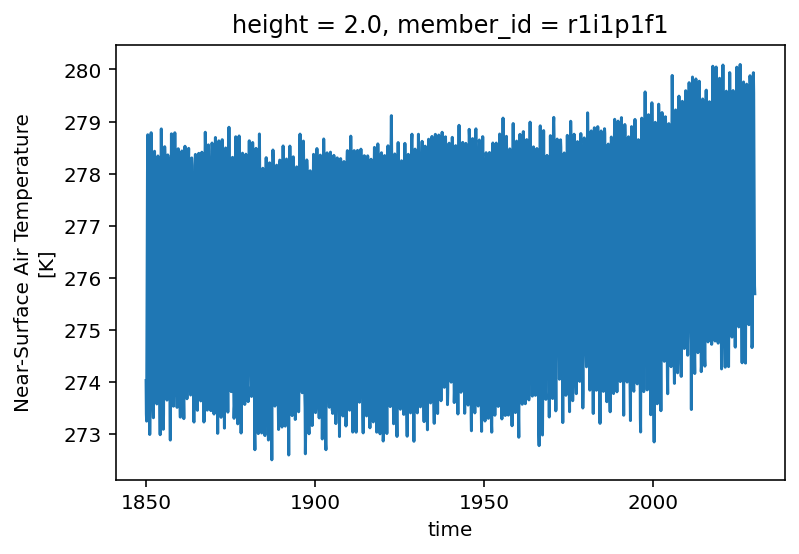

In [11]:
global_mean_cache.tas.plot()

In [30]:
global_mean_cache.tas

<xarray.DataArray 'tas' (member_id: 1, time: 2160)>
array([[274.0307 , 273.38684, 273.25174, ..., 276.95682, 275.84695,
        275.696  ]], dtype=float32)
Coordinates:
    height     float64 2.0
  * time       (time) object 1850-01-16 12:00:00 ... 2029-12-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2019-09-21T18:37:42Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    original_name:  TREFHT
    standard_name:  air_temperature
    units:          K

In [36]:
df_all = global_mean_cache.tas.to_dataframe().reset_index()
df_all

,member_id,time,height,tas
0,r1i1p1f1,1850-01-16 12:00:00,2.0,274.030701
1,r1i1p1f1,1850-02-15 00:00:00,2.0,273.386841
2,r1i1p1f1,1850-03-16 12:00:00,2.0,273.251740
3,r1i1p1f1,1850-04-16 00:00:00,2.0,274.776581
4,r1i1p1f1,1850-05-16 12:00:00,2.0,276.832306
...,...,...,...,...
2155,r1i1p1f1,2029-08-16 12:00:00,2.0,279.552216
2156,r1i1p1f1,2029-09-16 00:00:00,2.0,278.350861
2157,r1i1p1f1,2029-10-16 12:00:00,2.0,276.956818
2158,r1i1p1f1,2029-11-16 00:00:00,2.0,275.846954


In [37]:
global_mean_cache.attrs

{'Conventions': 'CF-1.7 CMIP-6.2',
 'activity_id': 'CMIP',
 'branch_method': 'perturbations to atmospheric fields were applied at the branch time',
 'branch_time': 674885.0,
 'branch_time_in_child': 674885.0,
 'branch_time_in_parent': 674885.0,
 'cmor_version': '3.5.0',
 'contact': 'Please send any requests or bug reports to norcpm@uib.no',
 'creation_date': '2019-09-21T18:37:42Z',
 'data_specs_version': '01.00.31',
 'experiment': 'all-forcing simulation of the recent past',
 'experiment_id': 'historical',
 'external_variables': 'areacella',
 'forcing_index': 1,
 'frequency': 'mon',
 'further_info_url': 'https://furtherinfo.es-doc.org/CMIP6.NCC.NorCPM1.historical.none.r1i1p1f1',
 'grid': 'finite-volume grid with 1.9x2.5 degree lat/lon resolution',
 'grid_label': 'gn',
 'history': '2019-09-21T18:37:42Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.',
 'initialization_index': 1,
 'institution': 'NorESM Climate modeling Consortium consisting of CICERO (

In [46]:
attributes = ['model_id', 'experiment_id', 'tracking_id', 'variable_id', 'intake_esm_dataset_key', 'table_id', 'institution_id', 'activity_id']
for attr in attributes:
    df_all[attr] = global_mean_cache.attrs[attr]
df_all['units'] = global_mean_cache.tas.units
df_all['region'] = 'global'
    


In [47]:
df_all

,member_id,time,height,tas,model_id,experiment_id,tracking_id,variable_id,intake_esm_dataset_key,table_id,institution_id,units,region,activity_id
0,r1i1p1f1,1850-01-16 12:00:00,2.0,274.030701,NorCPM1,historical,hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...,tas,CMIP.NCC.NorCPM1.historical.Amon.gn,Amon,NCC,K,global,CMIP
1,r1i1p1f1,1850-02-15 00:00:00,2.0,273.386841,NorCPM1,historical,hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...,tas,CMIP.NCC.NorCPM1.historical.Amon.gn,Amon,NCC,K,global,CMIP
2,r1i1p1f1,1850-03-16 12:00:00,2.0,273.251740,NorCPM1,historical,hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...,tas,CMIP.NCC.NorCPM1.historical.Amon.gn,Amon,NCC,K,global,CMIP
3,r1i1p1f1,1850-04-16 00:00:00,2.0,274.776581,NorCPM1,historical,hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...,tas,CMIP.NCC.NorCPM1.historical.Amon.gn,Amon,NCC,K,global,CMIP
4,r1i1p1f1,1850-05-16 12:00:00,2.0,276.832306,NorCPM1,historical,hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...,tas,CMIP.NCC.NorCPM1.historical.Amon.gn,Amon,NCC,K,global,CMIP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,r1i1p1f1,2029-08-16 12:00:00,2.0,279.552216,NorCPM1,historical,hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...,tas,CMIP.NCC.NorCPM1.historical.Amon.gn,Amon,NCC,K,global,CMIP
2156,r1i1p1f1,2029-09-16 00:00:00,2.0,278.350861,NorCPM1,historical,hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...,tas,CMIP.NCC.NorCPM1.historical.Amon.gn,Amon,NCC,K,global,CMIP
2157,r1i1p1f1,2029-10-16 12:00:00,2.0,276.956818,NorCPM1,historical,hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...,tas,CMIP.NCC.NorCPM1.historical.Amon.gn,Amon,NCC,K,global,CMIP
2158,r1i1p1f1,2029-11-16 00:00:00,2.0,275.846954,NorCPM1,historical,hdl:21.14100/00a5dee6-6d7b-487b-836d-b7163d30e...,tas,CMIP.NCC.NorCPM1.historical.Amon.gn,Amon,NCC,K,global,CMIP


In [48]:
df_all.to_csv('dummy_table.csv', index=False)